In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import Pauli, state_fidelity, Statevector

Below is the circuit that generates the shared state for our graph coloring strategy.

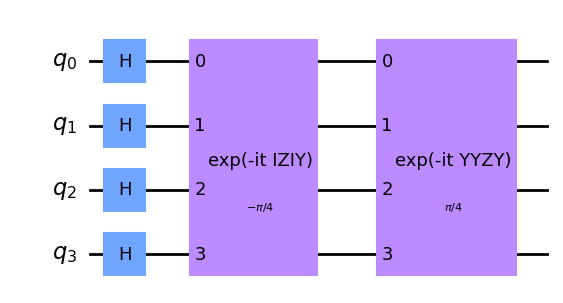

In [2]:
qc = QuantumCircuit(4)

for i in range(4):
    qc.h(i)

qc.append(PauliEvolutionGate(Pauli('IZIY'), -np.pi/4), [0, 1, 2, 3])
qc.append(PauliEvolutionGate(Pauli('YYZY'), +np.pi/4), [0, 1, 2, 3])

state = Statevector(qc)
qc.draw('mpl')

The circuit above generates the state

\begin{equation*}
\ket{\psi} = \frac{1}{2}H^{\otimes 4} \sum_{c \in [\chi_q]} \ket{cc}.
\end{equation*}

If we reorder the bits, grouping by significance (`AaBb` $\rightarrow$ `ABab`, or $SWAP_{12}$), we obtain

\begin{equation*}
\ket{\psi} = \frac{1}{2}H^{\otimes 4} \left( \ket{0000} + \ket{0011} + \ket{1100} + \ket{1111} \right)\\
= H^{\otimes 4} (\ket{\phi^+} \otimes \ket{\phi^+})
\end{equation*}

This means that Alice and Bob actually share 2 Bell states $\ket{\phi^+}$, paired on the bit significance (e.g. $a_0 \rightarrow b_0$, $a_1 \rightarrow b_1$). This is followed by $H$ gates on all qubits. We can create this much more compactly as follows.

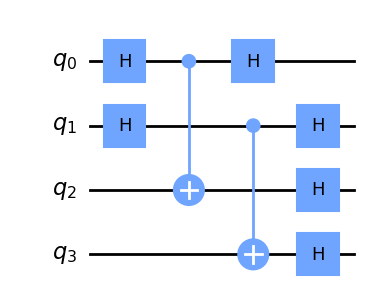

In [3]:
qc = QuantumCircuit(4)

for i in range(2):
    qc.h(i)
    qc.cx(i, i+2)

# qc.barrier()

for i in range(4):
    qc.h(i)

compressed = Statevector(qc)
qc.draw('mpl')

To verify these are the same, we compute the fidelity of the statevectors and see that they are indeed identical.

In [4]:
state_fidelity(state, compressed)

0.9999999999999971

This answers a few questions:

1. The strategy does not use a GHZ state. This means this is a unique strategy compared to any strategy that uses a GHZ state.

2. It is possible to compress our large 4-qubit unitary gates into just 2 CNOT gates. This should dramatically reduce noise.

Finally, let's create qasm files that use the old strategy parameters but the new state preparation circuit.

In [5]:
import glob
import os
import re

new_state_prep = """
qreg a[2];
qreg b[2];
creg ca[2];
creg cb[2];
h a[0];
h a[1];
cx a[0], b[0];
cx a[1], b[1];
h a[0];
h a[1];
h b[0];
h b[1];
"""

new_state_prep = re.sub(r"^\s+", "", new_state_prep, flags=re.MULTILINE)

In [6]:
old_dir = os.path.join('..', 'circuits', 'original')
new_dir = os.path.join('..', 'circuits', 'compressed')

for circuit_file in glob.glob(os.path.join(old_dir, '*.qasm')):
    with open(circuit_file, 'r', encoding='utf-8') as f:
        oldlines = f.readlines()
    
    # Old circuit state prep is lines 3-18, so we'll just splice together
    # what we want to keep
    new = ''.join(oldlines[0:2]) + new_state_prep + ''.join(oldlines[18:])

    with open(os.path.join(new_dir, os.path.basename(circuit_file)), 'w', encoding='utf-8') as f:
        f.write(new)